Forecast weekly sales for Walmart stores and departments using historical sales, economic indicators, and promotional data.

Target Variable: Weekly Sales

Problem Type: Supervised Regression (Time-aware)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [4]:
train = pd.read_csv("/content/drive/MyDrive/DATASET/train.csv")
features = pd.read_csv("/content/drive/MyDrive/DATASET/features.csv")
stores = pd.read_csv("/content/drive/MyDrive/DATASET/stores.csv")


In [5]:
train.head()
features.head()
stores.head()


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train.info()
features.info()
stores.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4  

In [7]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])


In [8]:
df = train.merge(features, on=['Store','Date'], how='left')
df = df.merge(stores, on='Store', how='left')


In [9]:
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


In [16]:
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True) #since there are 2 holidyas columnn created because of merging
df.drop(columns=['IsHoliday_y'], inplace=True)


In [10]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

df[markdown_cols] = df[markdown_cols].fillna(0)


 EDA

  Sales Distribution

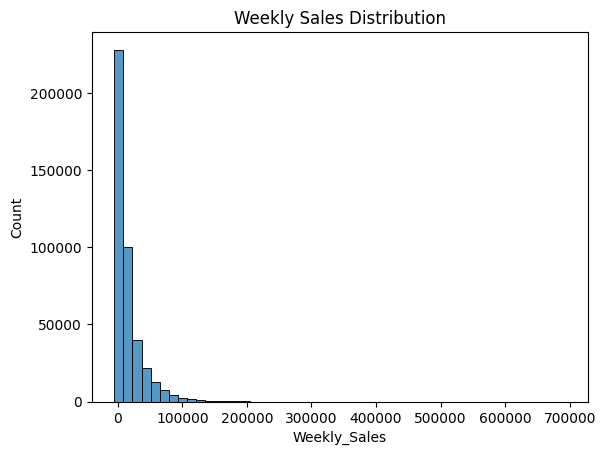

In [12]:
sns.histplot(df['Weekly_Sales'], bins=50)
plt.title("Weekly Sales Distribution")
plt.show()


In [17]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()



,Weekly_Sales
IsHoliday,
False,15901.445069
True,17035.823187


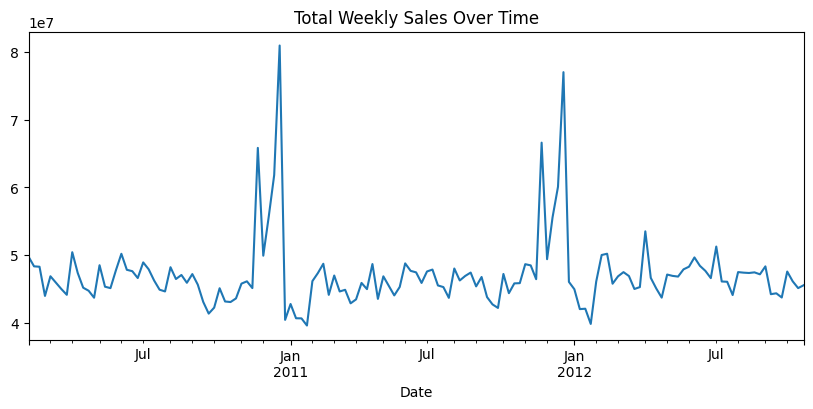

In [18]:
df.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(10,4))
plt.title("Total Weekly Sales Over Time")
plt.show()


Time based features

In [19]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week.astype(int)


lag features

In [20]:
df = df.sort_values(['Store','Dept','Date'])

df['lag_1'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
df['lag_4'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(4)


Rolling feature

In [21]:
df['rolling_mean_4'] = (
    df.groupby(['Store','Dept'])['Weekly_Sales']
    .shift(1)
    .rolling(4)
    .mean()
)


In [22]:
df.dropna(inplace=True) #Drop Rows with NA (Created due to lags


encoding

In [23]:
df = pd.get_dummies(df, columns=['Type'], drop_first=True)


define features and target

In [24]:
target = 'Weekly_Sales'

features = [
    'Store','Dept','IsHoliday','Temperature','Fuel_Price',
    'CPI','Unemployment','Size',
    'year','month','week',
    'lag_1','lag_4','rolling_mean_4'
]

X = df[features]
y = df[target]


TRAIN TEST SPLIT

In [25]:
split_date = '2012-01-01'

X_train = X[df['Date'] < split_date]
X_test  = X[df['Date'] >= split_date]

y_train = y[df['Date'] < split_date]
y_test  = y[df['Date'] >= split_date]


LINEAR REGRESSION

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


evaluation

In [34]:
rmse_lr =(mean_squared_error(y_test, y_pred_lr))**0.5
mae_lr = mean_absolute_error(y_test, y_pred_lr)

rmse_lr, mae_lr


(4414.836352803258, 2014.4425453993504)

RANDOM FOREST

In [35]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


evaluation

In [36]:
rmse_rf = (mean_squared_error(y_test, y_pred_rf))**0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_rf, mae_rf


(3544.7994800790298, 1587.5706846108892)

MODEL COMPARISON

In [37]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf]
})

comparison


,Model,RMSE,MAE
0,Linear Regression,4414.836353,2014.442545
1,Random Forest,3544.799480,1587.570685


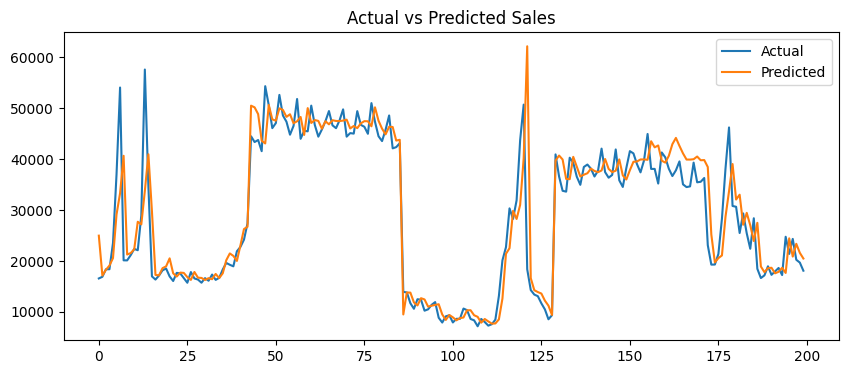

In [38]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_rf[:200], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()


important features (for random forest)

In [39]:
importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)


,0
lag_1,0.761746
rolling_mean_4,0.190230
lag_4,0.020715
week,0.011864
Dept,0.004903
IsHoliday,0.002321
Temperature,0.001696
Unemployment,0.001557
Fuel_Price,0.001252
Size,0.001130


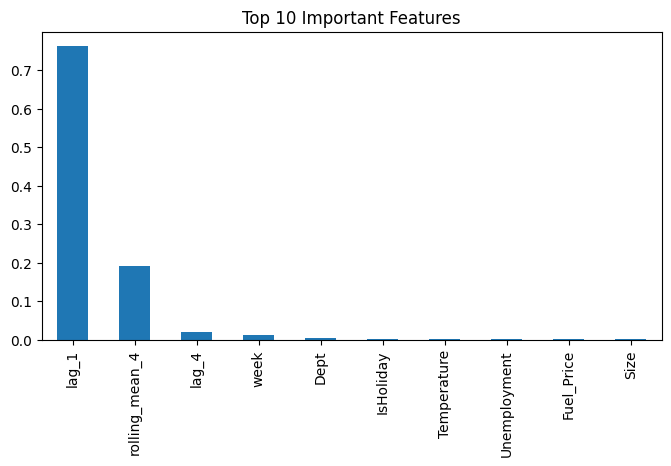

In [40]:
importance.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Important Features")
plt.show()


Lag-1 being important indicates strong temporal dependence in sales. The model primarily uses last week’s sales as a baseline and adjusts predictions based on promotions, holidays, and store characteristics. Rolling averages help smooth noise and capture short-term trends.”